In [ ]:
!python --version

Python 3.10.14


In [1]:
!pip install pyspark -U
!pip install wordcloud -U

In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# import os
# for dirname, _, filenames in os.walk('/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2021-10'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [7]:
from pyspark.sql.functions import when, col, lower, trim, avg, count, explode
from pyspark.sql.functions import col, explode, avg, lower, count
from pyspark.sql.functions import when, col, lower, avg, count, explode
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import plotly.express as px
from wordcloud import WordCloud

In [35]:
# Initialize Spark session
spark = SparkSession.builder.appName("JobOffersAnalysis").getOrCreate()

# Load JSON data
#data_path_2021 = [
    #"/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2021-10/*.json",
    #"/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2021-11/*.json",
    #"/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/2021-12/*.json"
#]
# reading all the available data for the years of 2021
#df = spark.read.json("/content/data/2021-10/2021-10-23.json")
df = spark.read.json("/content/data/*/*.json")

# reading all the available data for the years of 2021, 2022 and 2023
# df = spark.read.json("/kaggle/input/justjoinit-job-offers-data-2021-10-2023-09/*/*.json")

# Show the schema of the DataFrame
df.printSchema()

# # Display the first few rows of the DataFrame
# df.show()

root
 |-- address_text: string (nullable = true)
 |-- city: string (nullable = true)
 |-- company_logo_url: string (nullable = true)
 |-- company_name: string (nullable = true)
 |-- company_size: string (nullable = true)
 |-- company_url: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- display_offer: boolean (nullable = true)
 |-- employment_types: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- salary: struct (nullable = true)
 |    |    |    |-- currency: string (nullable = true)
 |    |    |    |-- from: long (nullable = true)
 |    |    |    |-- to: long (nullable = true)
 |    |    |-- type: string (nullable = true)
 |-- experience_level: string (nullable = true)
 |-- id: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- marker_icon: string (nullable = true)
 |-- multilocation: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    | 

# **Salary Analysis**

#High salaries for a particular experience level or skill may indicate a shortage of specialists in that area. This mean that companies are willing to pay more to find people with certain skills, so it makes sense to train people in those skills.


In [36]:
# Filtering
big_data_df = df.filter(
    (lower(col("title")).contains("big data")) |
    ((col("title").rlike("(?i).*big.*") | col("title").rlike("(?i).*analyst.*")) & col("title").rlike("(?i).*data.*"))
)

In [37]:
big_data_df.show()

+--------------------+--------+--------------------+--------------------+------------+--------------------+------------+-------------+--------------------+----------------+--------------------+----------+----------+-----------+--------------------+-----------------------+--------------------+------+----------------+--------------------+--------------------+--------------------+------------+--------------+
|        address_text|    city|    company_logo_url|        company_name|company_size|         company_url|country_code|display_offer|    employment_types|experience_level|                  id|  latitude| longitude|marker_icon|       multilocation|open_to_hire_ukrainians|        published_at|remote|remote_interview|              skills|              street|               title|way_of_apply|workplace_type|
+--------------------+--------+--------------------+--------------------+------------+--------------------+------------+-------------+--------------------+----------------+----------

In [38]:
employment_df = big_data_df.select(
    "experience_level",
    "workplace_type",
    "city",
    explode("skills").alias("skills"),
    explode("employment_types").alias("employment"),
)

In [39]:
employment_df.show()

+----------------+--------------+--------+--------------------+--------------------+
|experience_level|workplace_type|    city|              skills|          employment|
+----------------+--------------+--------+--------------------+--------------------+
|          junior|        remote|Warszawa|            {2, SQL}|{{pln, 18000, 220...|
|          junior|        remote|Warszawa|          {2, Scala}|{{pln, 18000, 220...|
|          junior|        remote|Warszawa|          {2, Spark}|{{pln, 18000, 220...|
|          senior| partly_remote| Wrocław|       {4, Power BI}|   {NULL, permanent}|
|          senior| partly_remote| Wrocław|       {4, Power BI}|         {NULL, b2b}|
|          senior| partly_remote| Wrocław|          {4, Azure}|   {NULL, permanent}|
|          senior| partly_remote| Wrocław|          {4, Azure}|         {NULL, b2b}|
|          senior| partly_remote| Wrocław|            {4, SQL}|   {NULL, permanent}|
|          senior| partly_remote| Wrocław|            {4, SQL}|  

In [40]:
employment_df = employment_df.select(
    "experience_level",
    "workplace_type",
    "city",
    col("skills.level").alias("skill_level"),
    col("skills.name").alias("skill_name"),
    col("employment.type").alias("employment_type"),
    col("employment.salary.currency").alias("employment_currency"),
    col("employment.salary.from").cast("int").alias("salary_from"),
    col("employment.salary.to").cast("int").alias("salary_to")
)

In [41]:
employment_df.show()

+----------------+--------------+--------+-----------+--------------------+---------------+-------------------+-----------+---------+
|experience_level|workplace_type|    city|skill_level|          skill_name|employment_type|employment_currency|salary_from|salary_to|
+----------------+--------------+--------+-----------+--------------------+---------------+-------------------+-----------+---------+
|          junior|        remote|Warszawa|          2|                 SQL|            b2b|                pln|      18000|    22000|
|          junior|        remote|Warszawa|          2|               Scala|            b2b|                pln|      18000|    22000|
|          junior|        remote|Warszawa|          2|               Spark|            b2b|                pln|      18000|    22000|
|          senior| partly_remote| Wrocław|          4|            Power BI|      permanent|               NULL|       NULL|     NULL|
|          senior| partly_remote| Wrocław|          4|        

In [42]:
big_data_currency_df = employment_df.filter(
    (col("employment_currency") == "pln") &
    (col("salary_from").isNotNull()) &
    (col("salary_to").isNotNull())
)

In [43]:
big_data_currency_df.show()

+----------------+--------------+--------+-----------+--------------------+---------------+-------------------+-----------+---------+
|experience_level|workplace_type|    city|skill_level|          skill_name|employment_type|employment_currency|salary_from|salary_to|
+----------------+--------------+--------+-----------+--------------------+---------------+-------------------+-----------+---------+
|          junior|        remote|Warszawa|          2|                 SQL|            b2b|                pln|      18000|    22000|
|          junior|        remote|Warszawa|          2|               Scala|            b2b|                pln|      18000|    22000|
|          junior|        remote|Warszawa|          2|               Spark|            b2b|                pln|      18000|    22000|
|             mid| partly_remote|Warszawa|          3|       Data modeling|            b2b|                pln|      11000|    22000|
|             mid| partly_remote|Warszawa|          3|       D

In [62]:

df_salaries = big_data_currency_df.select(
    "experience_level",
    "workplace_type",
    "skill_level",
    "employment_type",
    "employment_currency",
    "salary_from",
    "salary_to",
    "city",
     when(trim(lower(col("skill_name"))) == "powerbi", "Power BI")
    .when(trim(lower(col("skill_name"))) == "pyspark", "Apache Spark")
    .when(trim(lower(col("skill_name"))) == "spark", "Apache Spark")
    .when(trim(lower(col("skill_name"))) == "claudera", "Cloudera")
    .when(trim(lower(col("skill_name"))) == "apache hadoop", "Hadoop")
    .when(trim(lower(col("skill_name"))) == "haddop", "Hadoop")
    .when(trim(lower(col("skill_name"))) == "cdh", "Hadoop")
    .when(trim(lower(col("skill_name"))) == "hdfs", "Hadoop")
    .when(trim(lower(col("skill_name"))) == "hadoop or cloud solutions", "Hadoop")
    .when(trim(lower(col("skill_name"))) == "apache kafka", "Kafka")
    .when(trim(lower(col("skill_name"))) == "google cloud", "GCP")
    .when(trim(lower(col("skill_name"))) == "microsoft azure cloud", "Azure")
    .when(trim(lower(col("skill_name"))) == "sql db", "SQL")
    .when(trim(lower(col("skill_name"))) == "relational databases", "SQL")
    .when(trim(lower(col("skill_name"))) == "big data", "Big Data")
    .when(trim(lower(col("skill_name"))) == "bigdata", "Big Data")
    .when(trim(lower(col("skill_name"))) == "azure databricks", "Azure")
    .when(trim(lower(col("skill_name"))) == "azure data stack", "Azure")
    .when(trim(lower(col("skill_name"))) == "azure data brics", "Azure")
    .when(trim(lower(col("skill_name"))) == "excel", "Ms Excel")
    .when(trim(lower(col("skill_name"))) == "databrics", "Databricks")
    .when(trim(lower(col("skill_name"))) == "kubernetes", "Cloud Native")
    .when(trim(lower(col("skill_name"))) == "team player", "Communication Skills")
    .when(trim(lower(col("skill_name"))) == "dwh", "Data Warehousing")
    .when(trim(lower(col("skill_name"))) == "maxipanel", "Mixpanel")
    .when(trim(lower(col("skill_name"))) == "pandas", "Python")
    .when(trim(lower(col("skill_name"))) == "dbt", "ETL")
    .when(trim(lower(col("skill_name"))) == "numpy", "Python")
    .otherwise(col("skill_name")).alias("skill_name")
)


+----------------+--------------+----------------+---------+--------------+--------------+----------+
|experience_level|workplace_type|employment_type |job_count|avg_min_salary|avg_max_salary|avg_salary|
+----------------+--------------+----------------+---------+--------------+--------------+----------+
|senior          |partly_remote |b2b             |5718     |23068         |27706         |25387     |
|senior          |remote        |b2b             |52254    |21647         |28627         |25137     |
|senior          |office        |permanent       |357      |17915         |24739         |21327     |
|senior          |office        |b2b             |195      |15189         |25098         |20143     |
|senior          |partly_remote |permanent       |9138     |17174         |22594         |19884     |
|mid             |remote        |b2b             |42524    |16733         |22493         |19613     |
|senior          |remote        |permanent       |26986    |16139         |21431  

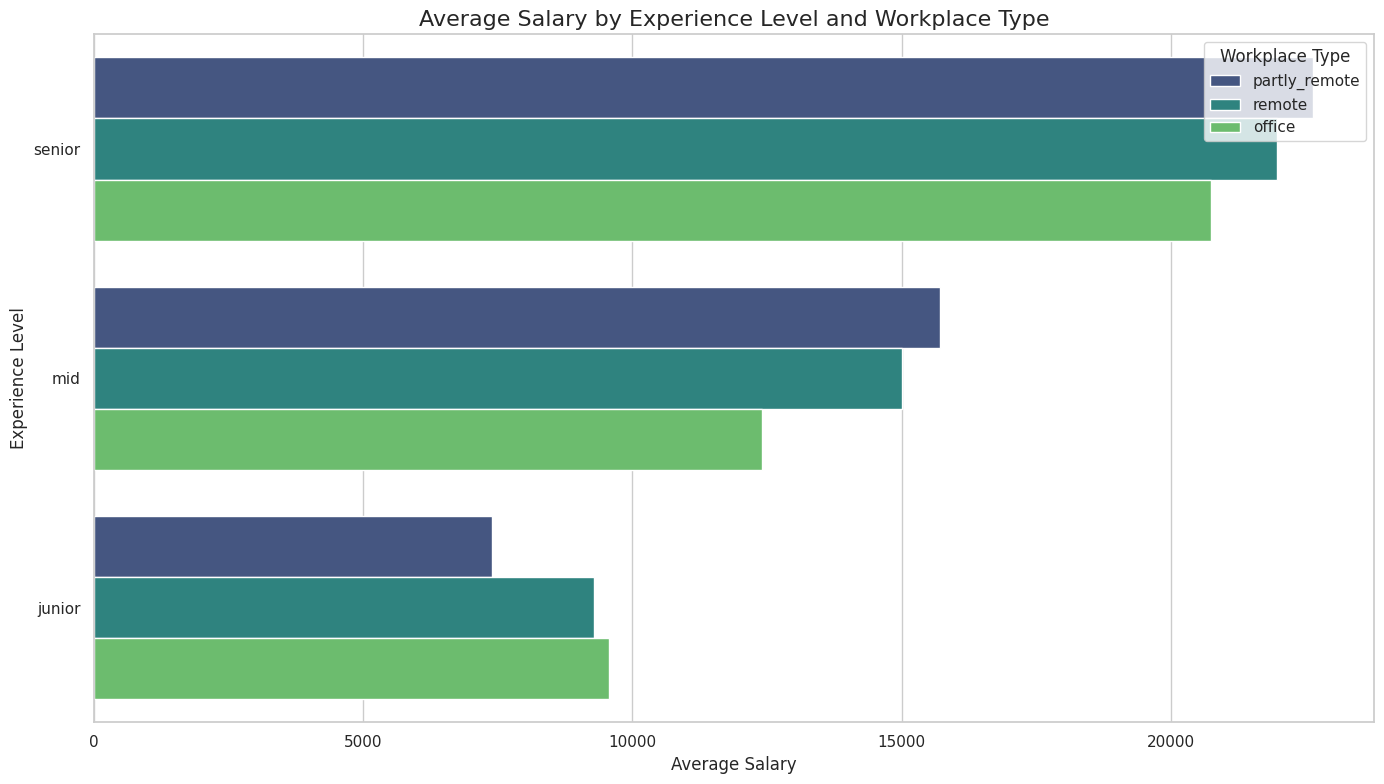

In [19]:
df_salaries_with_avg = df_salaries.withColumn(
    "average_salary", ((col("salary_from") + col("salary_to")) / 2).cast("int")
)

#Grouping by experience level, employment type and work place type
result_df = df_salaries_with_avg.groupBy(
    "experience_level", "workplace_type", "employment_type"
).agg(
    count("*").alias("job_count"),
    avg("salary_from").cast("int").alias("avg_min_salary"),
    avg("salary_to").cast("int").alias("avg_max_salary"),
    avg("average_salary").cast("int").alias("avg_salary")
).orderBy(col("avg_salary").desc())

result_df.show(truncate=False)

result_pd = result_df.toPandas()

# Graph
sns.set(style="whitegrid")

plt.figure(figsize=(14, 8))
sns.barplot(
    x="avg_salary",
    y="experience_level",
    hue="workplace_type",
    data=result_pd,
    palette="viridis",
    errorbar=None
)

plt.title("Average Salary by Experience Level and Workplace Type", fontsize=16)
plt.xlabel("Average Salary", fontsize=12)
plt.ylabel("Experience Level", fontsize=12)
plt.legend(title="Workplace Type", loc="upper right")

plt.tight_layout()
plt.show()


Senior employees working remotely and under B2B contracts have the highest average salaries, followed by mid-level employees in partly remote and B2B roles. Junior employees have significantly lower average salaries compared to other levels.

**Average Salary VS Demand for Big Data Skills**

Demand = The number of job offers that mention a specific skill.

This indicator gives an idea of how popular a particular skill is in the labor market.

**High demand and low wages** may indicate an “oversupplied market” (many workers already have the skill).

**Low demand and high salaries** may indicate a shortage of specialists with this skill, which is important for training planning.

**High demand and high salaries** indicate key areas that companies are willing to support with large investments.

In [53]:
# Calculate average salary and demand for each skill
skills_salary_df = df_salaries.withColumn(
    "average_salary", ((col("salary_from") + col("salary_to")) / 2).cast("int")
).groupBy("skill_name").agg(
    avg("average_salary").cast("int").alias("avg_salary"),
    count("*").alias("demand")
).orderBy(col("avg_salary").desc())

skills_salary_df.show(20, truncate=False)

+--------------------+----------+------+
|skill_name          |avg_salary|demand|
+--------------------+----------+------+
|People Management   |35000     |30    |
|Cloud Native        |34519     |441   |
|data flow           |32500     |180   |
|QuickSight          |31500     |30    |
|Open source         |31014     |581   |
|GCP/Azure/AWS       |30250     |24    |
|Cloud               |29941     |2458  |
|GCP                 |29335     |789   |
|NoSQL               |28871     |2987  |
|Shell Scripting     |28500     |60    |
|Maven               |28460     |155   |
|DDI                 |27500     |29    |
|Kafka               |26271     |2049  |
|BI tools            |26040     |127   |
|Spring              |25860     |198   |
|Databricks          |25532     |101   |
|BPMN                |25464     |192   |
|SAP ERP             |25000     |54    |
|Presto              |24750     |118   |
|Communication Skills|24708     |274   |
+--------------------+----------+------+
only showing top

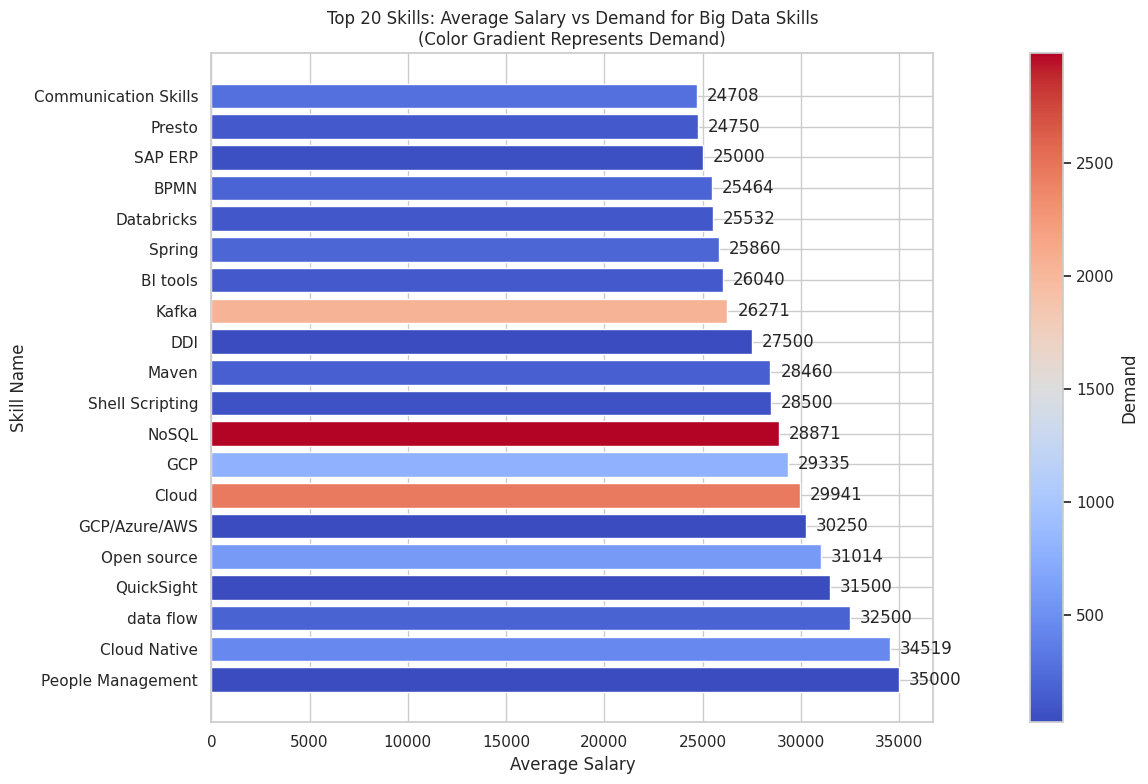

In [54]:
skills_salary_pd = skills_salary_df.toPandas()

# Filter top 20 skills by average salary
top_skills_salary_pd = skills_salary_pd.nlargest(20, "avg_salary")

# Data for graph (Top 20 only)
skills = top_skills_salary_pd["skill_name"].tolist()
avg_salary = top_skills_salary_pd["avg_salary"].tolist()
demand = top_skills_salary_pd["demand"].tolist()

# Normalize demand for a color gradient
normalized_demand = (np.array(demand) - min(demand)) / (max(demand) - min(demand))

cmap = sns.color_palette("coolwarm", as_cmap=True)

# Size of graph
fig, ax = plt.subplots(figsize=(12, 8))

bars = ax.barh(skills, avg_salary, color=cmap(normalized_demand))

# Add labels to the bars
for bar, salary in zip(bars, avg_salary):
    ax.text(bar.get_width() + 500, bar.get_y() + bar.get_height() / 2, f'{salary}', va='center')

# Set labels and title
ax.set_xlabel("Average Salary")
ax.set_ylabel("Skill Name")
ax.set_title("Top 20 Skills: Average Salary vs Demand for Big Data Skills\n(Color Gradient Represents Demand)")

# Add color bar for demand
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(demand), vmax=max(demand)))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.1)
cbar.set_label("Demand")

plt.tight_layout()
plt.show()



**NoSQL:** High salary (35 000) and low demand (20). This could suggest a specialist shortage.

**GCP/Azure/AWS:** High salary (30 250) and low demand (24).

**Big Data:** The highest demand (890) with an average salary of 18 145. This reflects a stable market but an opportunity to scale training efforts.

**Python:** High demand (606), but the average salary is slightly lower.

Some skills, such as NoSQL or GCP/Azure/AWS, show high salaries and low demand, which might indicate a shortage of professionals.

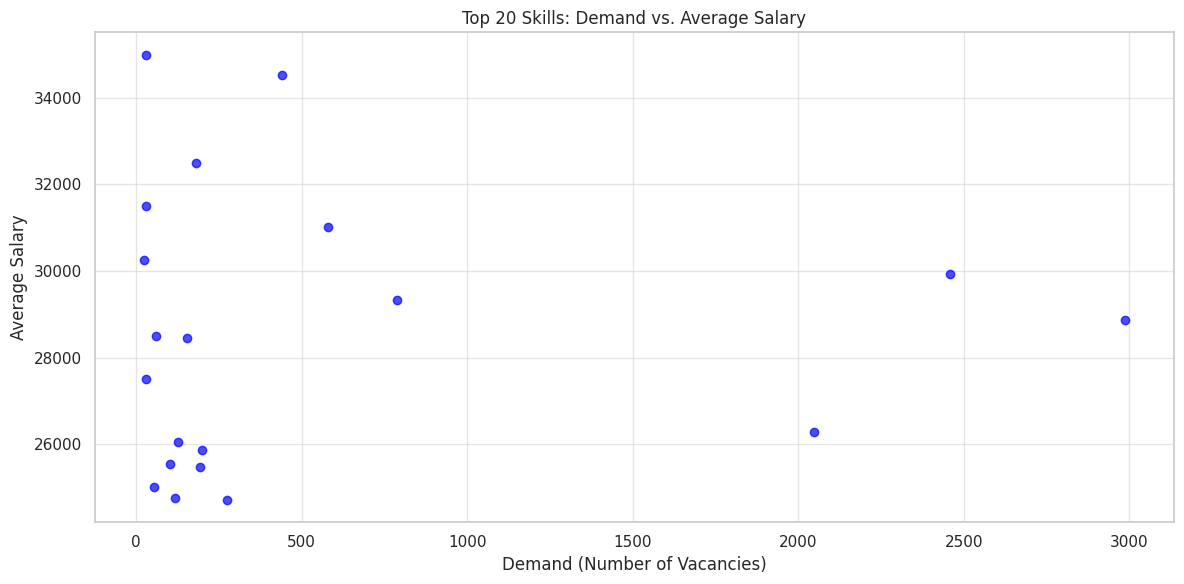

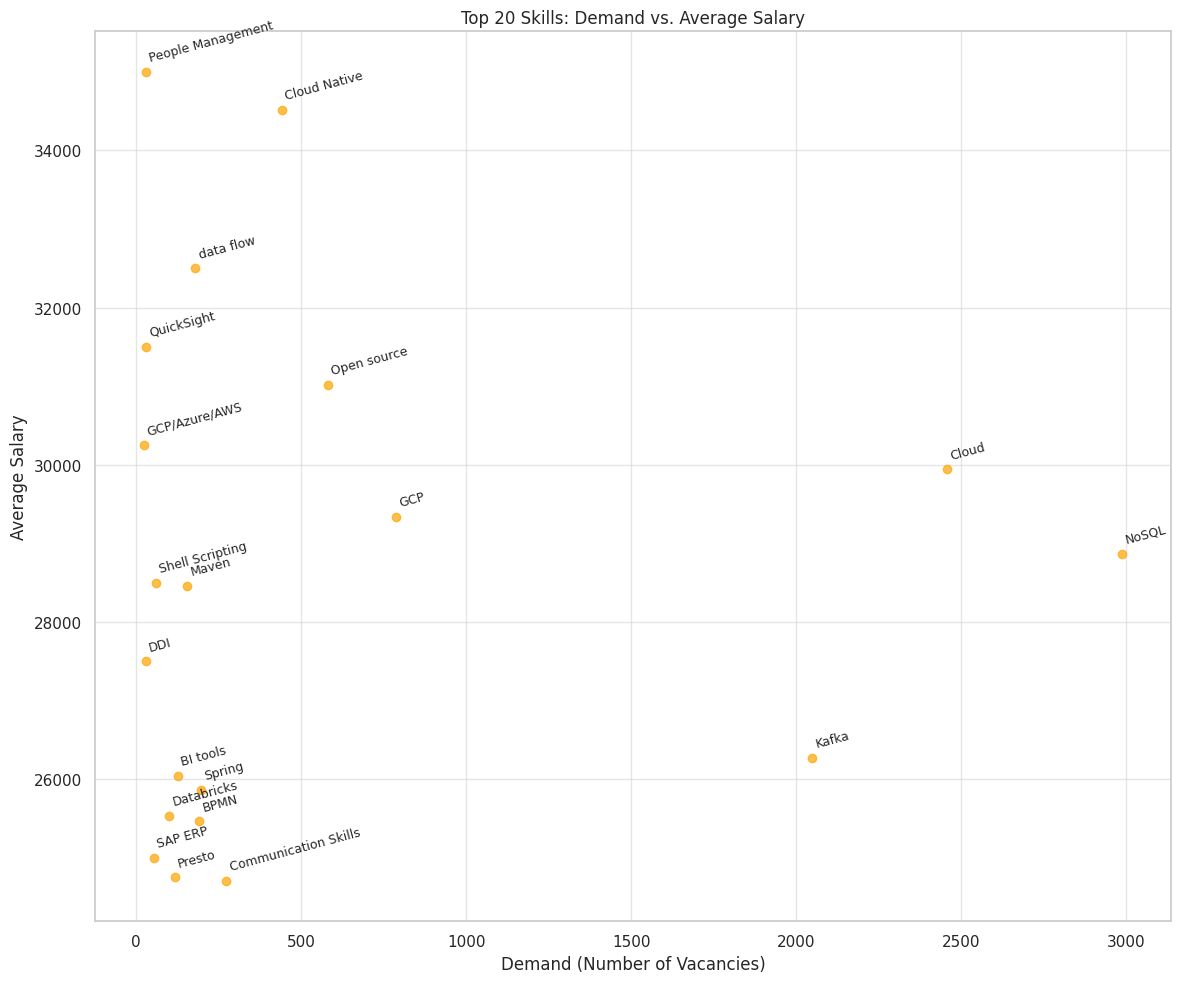

In [55]:
# Filter top 20 skills by average salary
top_skills_salary_pd = skills_salary_pd.nlargest(20, "avg_salary")

# Scatter Plot for Top 20 Skills
plt.figure(figsize=(12, 6))
plt.scatter(top_skills_salary_pd["demand"], top_skills_salary_pd["avg_salary"], alpha=0.7, color="blue")
plt.title("Top 20 Skills: Demand vs. Average Salary")
plt.xlabel("Demand (Number of Vacancies)")
plt.ylabel("Average Salary")
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

# Scatter Plot with Labels for Top 20 Skills
# Data for graph
skills = top_skills_salary_pd["skill_name"].tolist()
avg_salary = top_skills_salary_pd["avg_salary"].tolist()
demand = top_skills_salary_pd["demand"].tolist()

# Graph with Labels
plt.figure(figsize=(12, 10))
plt.scatter(demand, avg_salary, alpha=0.7, color="orange")

for i, skill in enumerate(skills):
    plt.text(demand[i] + 5, avg_salary[i] + 100, skill, fontsize=9, rotation=15, ha='left', va='bottom')

plt.title("Top 20 Skills: Demand vs. Average Salary")
plt.xlabel("Demand (Number of Vacancies)")
plt.ylabel("Average Salary")
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()


**The relationship between salaries and demand for skills:**

To check whether skills with high salaries are the most in demand.

Clusters of skills that are highly paid but in low demand (possible shortages).


**Training Hypothesis**

In [63]:
# Average salary for each experience level and skill
skills_salary_df = df_salaries.withColumn(
    "average_salary", ((col("salary_from") + col("salary_to")) / 2).cast("int")
).groupBy("skill_name", "experience_level").agg(
    avg("average_salary").cast("int").alias("avg_salary"),
    count("*").alias("demand")
).orderBy(col("avg_salary").desc())

skills_salary_df.show(50, truncate=False)


+---------------------+----------------+----------+------+
|skill_name           |experience_level|avg_salary|demand|
+---------------------+----------------+----------+------+
|Cloud Native         |mid             |36890     |353   |
|GCP                  |mid             |36698     |375   |
|People Management    |senior          |35000     |30    |
|Cloudera             |senior          |32636     |57    |
|data flow            |senior          |32500     |180   |
|QuickSight           |senior          |31500     |30    |
|Open source          |senior          |31014     |581   |
|GCP/Azure/AWS        |senior          |30250     |24    |
|Flink                |senior          |30000     |108   |
|NoSQL                |mid             |29971     |1281  |
|Cloud                |senior          |29941     |2458  |
|Kafka                |mid             |28806     |401   |
|Shell Scripting      |mid             |28500     |60    |
|Maven                |mid             |28460     |155  

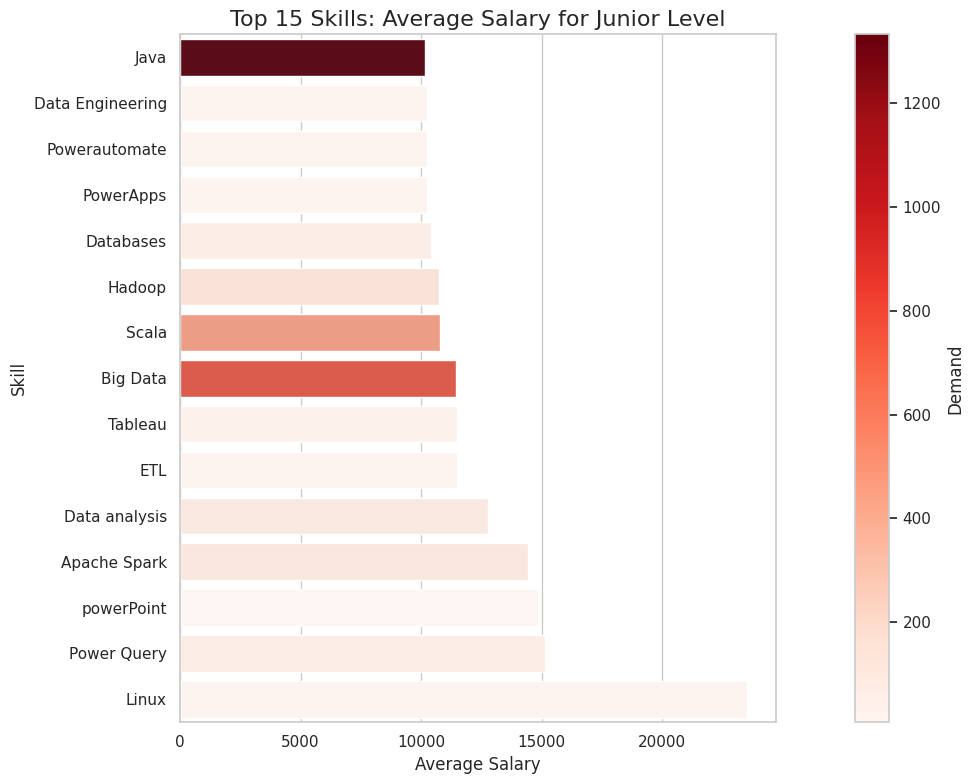

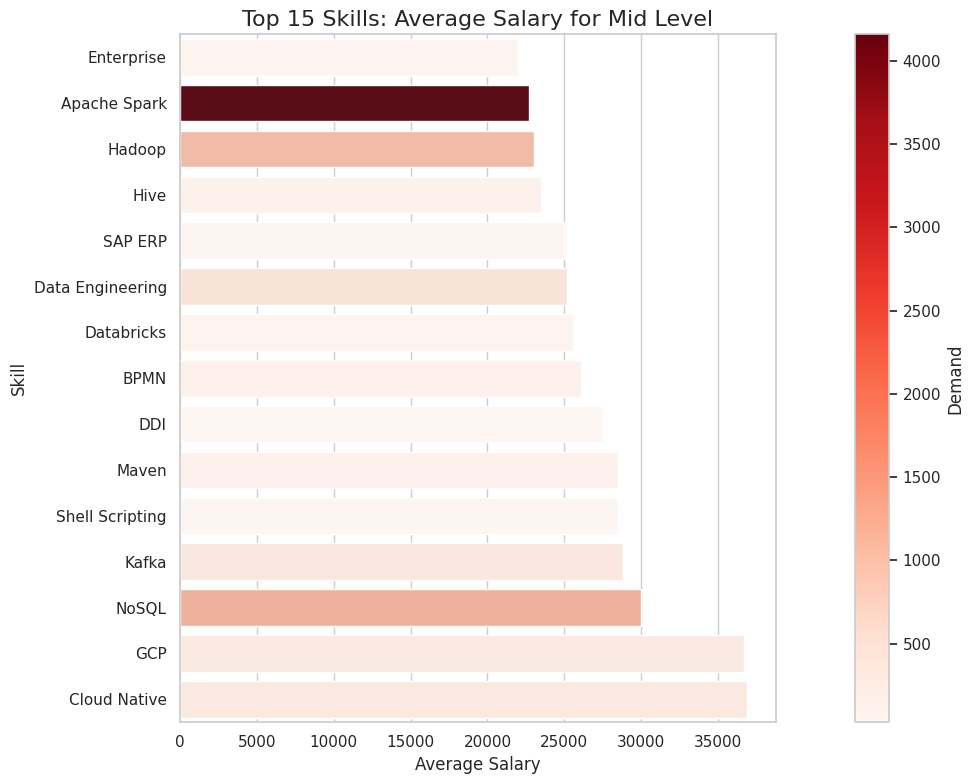

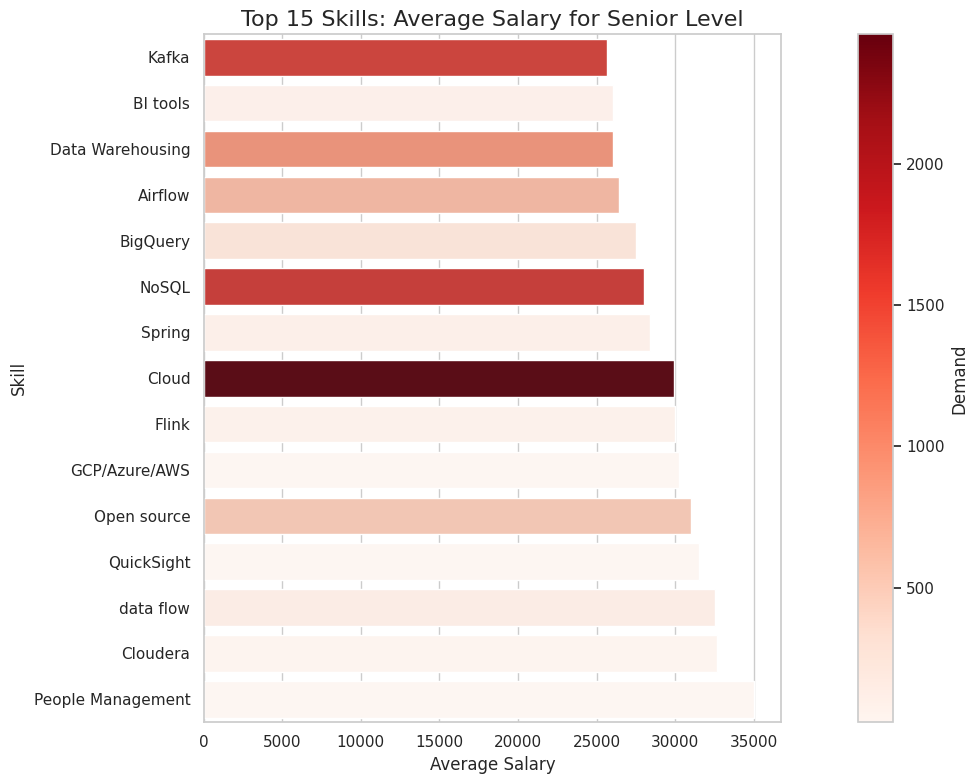

In [64]:
skills_salary_pd = skills_salary_df.toPandas()

experience_levels = ["junior", "mid", "senior"]

# Graphs for every experince level
for level in experience_levels:

    level_data = skills_salary_pd[skills_salary_pd["experience_level"] == level]
    level_data = level_data.nlargest(15, "avg_salary")

    norm = Normalize(vmin=level_data["demand"].min(), vmax=level_data["demand"].max())
    cmap = plt.cm.Reds


    fig, ax = plt.subplots(figsize=(10, 8))
    sns.barplot(
        data=level_data.sort_values(by="avg_salary", ascending=True),
        x="avg_salary",
        y="skill_name",
        ax=ax,
        hue="skill_name",
        dodge=False,
        palette={skill: cmap(norm(value)) for skill, value in zip(level_data["skill_name"], level_data["demand"])},
        errorbar=None,
        legend=False
    )


    sm = ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.1)
    cbar.set_label("Demand")

    ax.set_title(f"Top 15 Skills: Average Salary for {level.capitalize()} Level", fontsize=16)
    ax.set_xlabel("Average Salary", fontsize=12)
    ax.set_ylabel("Skill", fontsize=12)

    plt.tight_layout()
    plt.show()


**High salary for Senior but low demand indicating a potential shortage of specialists**: This hypothesis is valid as skills like NoSQL and GCP/Azure/AWS show high salaries for seniors with relatively low demand, which can suggest a lack of available experts.

**High salary for Mid/Junior with high demand being the best zone for training investment**: This hypothesis is partially valid, as skills like Big Data and Python show high demand and moderate salaries for Mid/Junior levels, making them ideal for training investment. However, not all high-demand skills necessarily offer equally high salaries for these levels.

**Skills with high salaries but low job openings indicating a shortage of specialists across all levels**: This hypothesis is partially valid but depends on the skill. Some skills like Shell Scripting or Hive fit this scenario, but others may have low demand due to niche applications, not necessarily because of a shortage.

In [65]:
# Average salary and demand grouped by regions and experience levels
skills_salary_with_geo_df = df_salaries.withColumn(
    "average_salary", ((col("salary_from") + col("salary_to")) / 2).cast("int")
).groupBy("skill_name", "experience_level", "city").agg(
    avg("average_salary").cast("int").alias("avg_salary"),
    count("*").alias("demand")
).orderBy(col("avg_salary").desc())

skills_salary_with_geo_df.show(20, truncate=False)

+-----------------+----------------+------------+----------+------+
|skill_name       |experience_level|city        |avg_salary|demand|
+-----------------+----------------+------------+----------+------+
|GCP              |mid             |Katowice    |38000     |54    |
|Cloud Native     |mid             |Gdańsk      |38000     |54    |
|GCP              |mid             |Kraków      |38000     |54    |
|GCP              |mid             |Wrocław     |38000     |54    |
|Cloud Native     |mid             |Katowice    |38000     |54    |
|Cloud Native     |mid             |Warszawa    |38000     |54    |
|GCP              |mid             |Poznań      |38000     |54    |
|Cloud Native     |mid             |Wrocław     |38000     |54    |
|Cloud Native     |mid             |Poznań      |38000     |54    |
|Cloud Native     |mid             |Kraków      |38000     |54    |
|GCP              |mid             |Gdańsk      |38000     |54    |
|People Management|senior          |Warszawa    

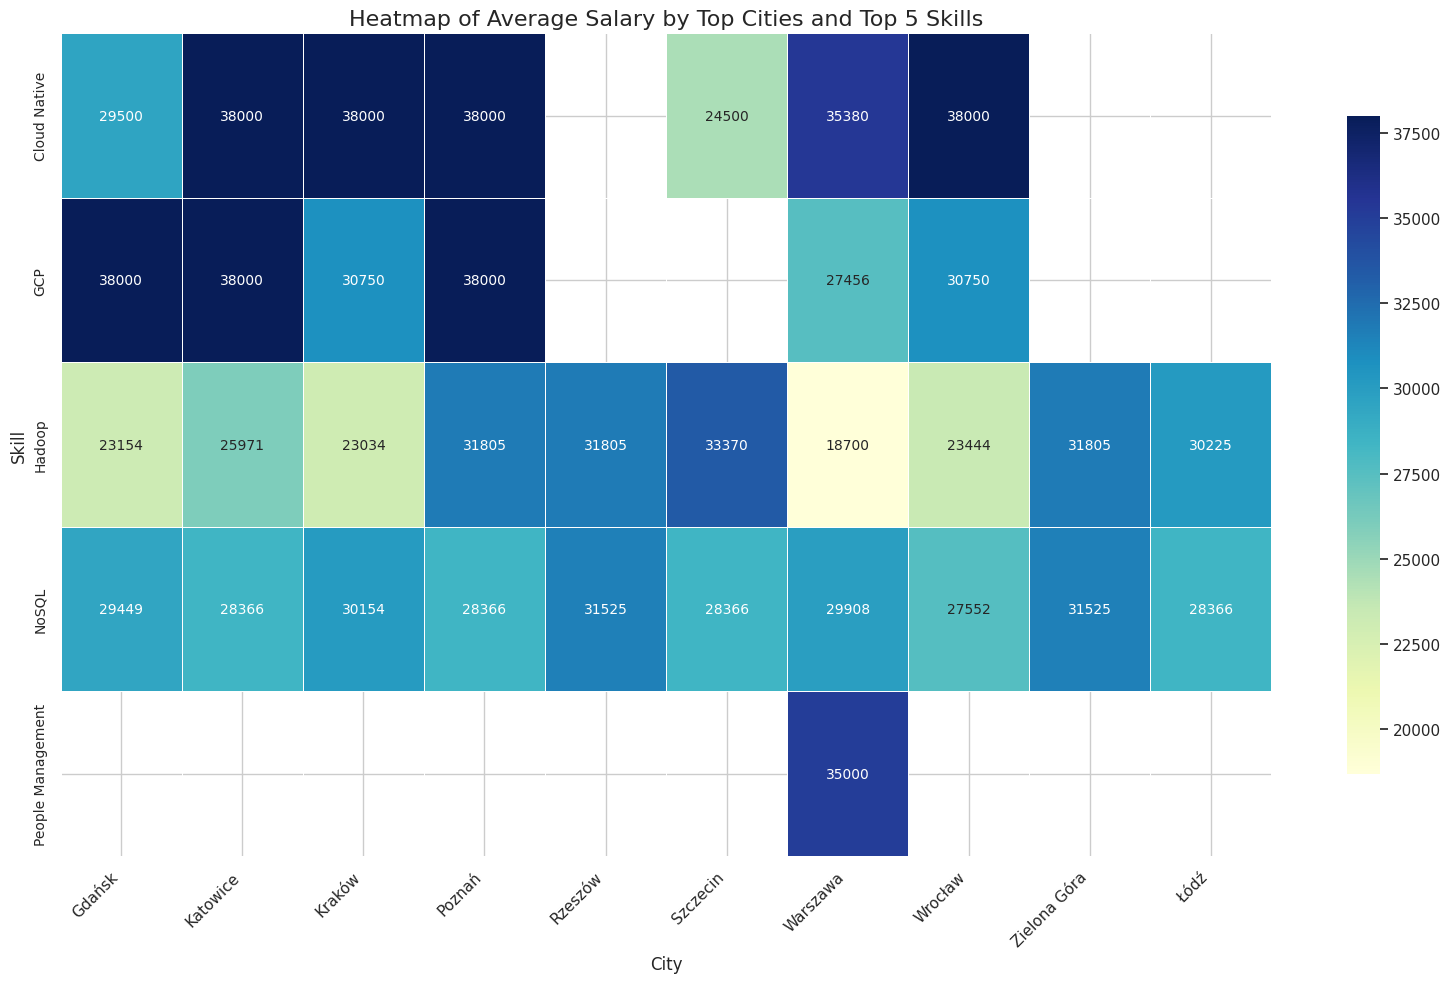

In [66]:
skills_salary_with_geo_pd = skills_salary_with_geo_df.toPandas()
top_skills = skills_salary_with_geo_pd.nlargest(15, "avg_salary")["skill_name"]

filtered_data = skills_salary_with_geo_pd[skills_salary_with_geo_pd["skill_name"].isin(top_skills)]

top_cities = filtered_data["city"].value_counts().head(10).index
heatmap_data = filtered_data[filtered_data["city"].isin(top_cities)].pivot_table(
    index="skill_name",
    columns="city",
    values="avg_salary",
    aggfunc="mean"
)


plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    annot=True,
    fmt=".0f",
    linewidths=.5,
    annot_kws={"size": 10},
    cbar_kws={"shrink": 0.8}
)
plt.title("Heatmap of Average Salary by Top Cities and Top 5 Skills", fontsize=16)
plt.xlabel("City", fontsize=12)
plt.ylabel("Skill", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()
